In [1]:
import os, sys
import time
import random
import glob
import numpy as np
import pickle
import bisect

import matplotlib.pyplot as plt

from scipy.integrate import ode, solve_ivp, odeint
from scipy.optimize import curve_fit, least_squares
from scipy.optimize import minimize



import multiprocessing
from functools import partial 

from PIL import Image
from IPython.display import Image as Img
from IPython import display

import myokit

sys.path.append('../../../JKLib')
from pythonJK1 import create_folder
from metricJK import MSE

In [2]:
dataset_dir = 'Kylie'
parameter_ranges = []
if 'Kylie' in dataset_dir:    
    if 'rmax600' in dataset_dir:
        # Kylie: rmax = 600 
        parameter_ranges = []
        parameter_ranges.append( [100, 500000] )
        parameter_ranges.append( [0.0001, 598] )
        parameter_ranges.append( [0.0001, 260] )
        parameter_ranges.append( [0.0001, 598] )
        parameter_ranges.append( [0.0001, 130] )
        parameter_ranges.append( [0.0001, 598] )
        parameter_ranges.append( [0.0001, 260] )
        parameter_ranges.append( [0.0001, 598] )
        parameter_ranges.append( [0.0001, 130] )
        print("Kylie-rmax600 dataset has been selected.")
    else :
        # Kylie
        parameter_ranges.append([100, 500000])
        parameter_ranges.append( [0.0001, 1000000])
        parameter_ranges.append( [0.0001, 384])
        parameter_ranges.append( [0.0001, 1000000] )
        parameter_ranges.append( [0.0001, 192] )
        parameter_ranges.append( [0.0001, 1000000] )
        parameter_ranges.append( [0.0001, 384] )
        parameter_ranges.append( [0.0001, 1000000] )
        parameter_ranges.append( [0.0001, 192] )
        print("Kylie dataset has been selected.")

elif 'RealRange' in dataset_dir:
        parameter_ranges.append([3134, 500000])                 # g
        parameter_ranges.append( [0.0001, 2.6152843264828003])  # p1
        parameter_ranges.append( [43.33271226094526, 259])      # p2
        parameter_ranges.append( [0.001, 0.5] )                 # p3
        parameter_ranges.append( [15, 75] )                     # p4
        parameter_ranges.append( [0.8, 410] )                   # p5
        parameter_ranges.append( [0.0001, 138.] )               # p6
        parameter_ranges.append( [1.0, 59] )                    # p7
        parameter_ranges.append( [1.6, 90] )                    # p8
        print("RealRange dataset has been selected.")

parameter_ranges = np.array(parameter_ranges)
print(parameter_ranges.shape)


Kylie dataset has been selected.
(9, 2)


In [4]:
result_folder = './Figures'
create_folder(result_folder)

fit_seed = 542811797
print('Using seed: ', fit_seed)
np.random.seed(fit_seed)

The folder already exists.
Using seed:  542811797


In [4]:
param_names = ['g', 'p1', 'p2', 'p3', 'p4', 'p5', 'p6', 'p7', 'p8']
def normalize_params(params):
                
    normalized_parameter = copy.copy(params)
    for i, p_name in enumerate(param_names):
        if p_name in ['p1', 'p3', 'p5', 'p7']:        
            normalized_parameter[:,i] = ( np.log(normalized_parameter[:,i]) - np.log(parameter_ranges[i,0]) ) / ( np.log(parameter_ranges[i,1]) - np.log(parameter_ranges[i,0]) )
        else:
            normalized_parameter[:,i] = (normalized_parameter[:,i] - parameter_ranges[i,0]) / (parameter_ranges[i,1] - parameter_ranges[i,0])

    return normalized_parameter

In [5]:
cell = 'G01'

params_file_name = 'herg25oc1-staircaseramp-' + cell + '-solution-' + str(fit_seed) +'-dt001.txt'
real_p = np.loadtxt('../herg25oc1_real_data/' + params_file_name) # headers
params_file_name = 'predicted_params-' + cell + '.txt'                     
ai_p = np.loadtxt('../predicted_params_efficientNet6_Kylie/' + params_file_name) # headers
prior_p = np.array([1.95996752e+05, 2.96501898e-01, 6.59164494e+01, 4.62717921e-02, 4.97958442e+01, 1.07192891e+02, 7.96790797e+00, 6.54624352e+00, 3.14264169e+01])

print(real_p)    
print(ai_p)    
print(prior_p)    

[2.25261129e+04 8.06355949e-02 9.62892813e+01 3.86384612e-02
 4.52003131e+01 1.00332854e+02 2.54436833e+01 6.69264102e+00
 3.30580365e+01]
[1.77468809e+04 9.35755968e-02 1.24885017e+02 6.80887997e-02
 3.90921974e+01 1.46032898e+03 3.94074135e+01 4.93528862e+01
 2.13063087e+01]
[1.95996752e+05 2.96501898e-01 6.59164494e+01 4.62717921e-02
 4.97958442e+01 1.07192891e+02 7.96790797e+00 6.54624352e+00
 3.14264169e+01]


In [6]:
import leakstaircase
import kylie2017IKr

protocol = leakstaircase.LeakStaircase()
kylie = kylie2017IKr.Kylie2017IKr(protocol)
times = np.linspace(0, 15.4, 77000)
times = np.arange(77000)*0.0002
times = np.arange(1540)*0.01
print(times.shape, times.max())

Kylie dataset has been selected.
(9, 2)
(1540,) 15.39


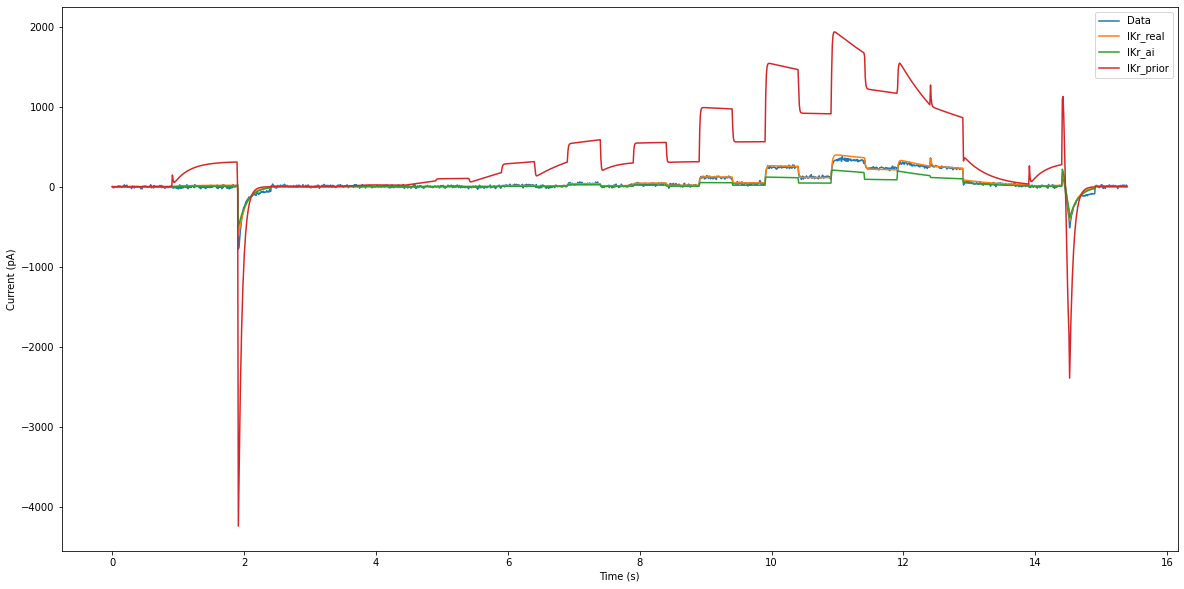

Simulation done.


In [7]:
# Load data
data_file = "herg25oc1-staircaseramp-%s.csv"%(cell)
data = np.loadtxt('../herg25oc1_real_data/' + data_file, delimiter=',', skiprows=1)[::50] # headers

IKr = kylie.simulate_odeint(times, real_p[0], real_p[1], real_p[2], real_p[3], real_p[4], real_p[5], real_p[6], real_p[7], real_p[8])
IKr_ai = kylie.simulate_odeint(times, ai_p[0], ai_p[1], ai_p[2], ai_p[3], ai_p[4], ai_p[5], ai_p[6], ai_p[7], ai_p[8])
IKr_prior = kylie.simulate_odeint(times, prior_p[0], prior_p[1], prior_p[2], prior_p[3], prior_p[4], prior_p[5], prior_p[6], prior_p[7], prior_p[8])

fig, ax = plt.subplots(figsize=(20,10))    
# fig.suptitle('New ORD-hERG - '+ ord._cell_types[cell_mode] +' cell', fontsize=16)
# ax.set_title('Simulation %d'%(simulationNo))
plt.xlabel('Time (s)')
plt.ylabel('Current (pA)')     
ax.plot(times, data, label='Data')
ax.plot(times, IKr, label='IKr_real')
ax.plot(times, IKr_ai, label='IKr_ai') 
ax.plot(times, IKr_prior, label='IKr_prior') 
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
#     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
#     fig1 = plt.gcf()
ax.legend(loc='best')
plt.show()
# fig.savefig(os.path.join(result_folder, "%s-Curve-fitting.jpg"%(cell)), dpi=100)

print("Simulation done.")

In [8]:
method = 'trf'  # method{‘lm’, ‘trf’, ‘dogbox’},
bounds = ([parameter_ranges[0,0], parameter_ranges[1,0], parameter_ranges[2,0], parameter_ranges[3,0], parameter_ranges[4,0], parameter_ranges[5,0], parameter_ranges[6,0], parameter_ranges[7,0], parameter_ranges[8,0]], 
          [parameter_ranges[0,1], parameter_ranges[1,1], parameter_ranges[2,1], parameter_ranges[3,1], parameter_ranges[4,1], parameter_ranges[5,1], parameter_ranges[6,1], parameter_ranges[7,1], parameter_ranges[8,1]])

In [9]:
start_time = time.time()
p_fit_by_real = kylie.curve_fitting(times, data, p0=real_p, bounds=bounds ,method=method)
print("--- %s seconds ---"%(time.time()-start_time))                
fit_I_real = kylie.simulate_odeint(times, p_fit_by_real[0], p_fit_by_real[1], p_fit_by_real[2], p_fit_by_real[3], p_fit_by_real[4], p_fit_by_real[5], p_fit_by_real[6], p_fit_by_real[7], p_fit_by_real[8])

--- 11.32707691192627 seconds ---


In [10]:
for i, name in enumerate(param_names):
    print("%s - Prediction : %f | Exact : %f"%(name, p_fit_by_real[i], real_p[i]))

g - Prediction : 22526.110991 | Exact : 22526.112895
p1 - Prediction : 0.080289 | Exact : 0.080636
p2 - Prediction : 96.270258 | Exact : 96.289281
p3 - Prediction : 0.038613 | Exact : 0.038638
p4 - Prediction : 45.233780 | Exact : 45.200313
p5 - Prediction : 100.303773 | Exact : 100.332854
p6 - Prediction : 25.437106 | Exact : 25.443683
p7 - Prediction : 6.675475 | Exact : 6.692641
p8 - Prediction : 33.051433 | Exact : 33.058036


In [11]:
start_time = time.time()
p_fit_by_ai = kylie.curve_fitting(times, data, p0=ai_p, bounds=bounds ,method=method)
print("--- %s seconds ---"%(time.time()-start_time))     
fit_I_ai = kylie.simulate_odeint(times, p_fit_by_ai[0], p_fit_by_ai[1], p_fit_by_ai[2], p_fit_by_ai[3], p_fit_by_ai[4], p_fit_by_ai[5], p_fit_by_ai[6], p_fit_by_ai[7], p_fit_by_ai[8])

--- 15.960778951644897 seconds ---


In [12]:
for i, name in enumerate(param_names):
    print("%s - Prediction : %f | Exact : %f"%(name, p_fit_by_ai[i], real_p[i]))

g - Prediction : 29639.760419 | Exact : 22526.112895
p1 - Prediction : 0.101109 | Exact : 0.080636
p2 - Prediction : 121.121367 | Exact : 96.289281
p3 - Prediction : 0.075450 | Exact : 0.038638
p4 - Prediction : 40.035084 | Exact : 45.200313
p5 - Prediction : 1466.983310 | Exact : 100.332854
p6 - Prediction : 39.919699 | Exact : 25.443683
p7 - Prediction : 51.850820 | Exact : 6.692641
p8 - Prediction : 21.129914 | Exact : 33.058036


In [13]:
start_time = time.time()
p_fit_by_prior = kylie.curve_fitting(times, data, p0=prior_p, bounds=bounds ,method=method)
print("--- %s seconds ---"%(time.time()-start_time))     
fit_I_prior = kylie.simulate_odeint(times, p_fit_by_prior[0], p_fit_by_prior[1], p_fit_by_prior[2], p_fit_by_prior[3], p_fit_by_prior[4], p_fit_by_prior[5], p_fit_by_prior[6], p_fit_by_prior[7], p_fit_by_prior[8])

--- 24.736221313476562 seconds ---


In [14]:
for i, name in enumerate(param_names):
    print("%s - Prediction : %f | Exact : %f"%(name, p_fit_by_prior[i], real_p[i]))

g - Prediction : 27783.747660 | Exact : 22526.112895
p1 - Prediction : 0.280826 | Exact : 0.080636
p2 - Prediction : 65.296844 | Exact : 96.289281
p3 - Prediction : 0.025247 | Exact : 0.038638
p4 - Prediction : 48.868160 | Exact : 45.200313
p5 - Prediction : 107.570395 | Exact : 100.332854
p6 - Prediction : 7.998782 | Exact : 25.443683
p7 - Prediction : 6.331054 | Exact : 6.692641
p8 - Prediction : 33.781245 | Exact : 33.058036


In [15]:
print("MSE for real :", MSE(IKr, data, axis=0))
print("MSE for fit_real :", MSE(fit_I_real, data, axis=0))
print("MSE for fit_ai :", MSE(fit_I_ai, data, axis=0))
print("MSE for fit_prior :", MSE(fit_I_prior, data, axis=0))

MSE for real : 463.4242192588063
MSE for fit_real : 461.7135317660474
MSE for fit_ai : 1119.0437738865526
MSE for fit_prior : 816.3909479232416


In [16]:
fasffa

NameError: name 'fasffa' is not defined

In [ ]:
import cma
# help(cma)

# Set up simulation
options = cma.CMAOptions()

# Tell cma-es to be quiet
options.set('verbose', -9)

# Set population size
options.set('popsize', 2)

# CMAES always seeds np.random, whether you ask it too or not, so to
# get consistent debugging output, we should always pass in a seed.
# Instead of using a fixed number (which would be bad), we can use a
# randomly generated number: This will ensure pseudo-randomness, but
# produce consistent results if np.random has been seeded before
# calling.
options.set('seed', np.random.randint(2**31))

es = cma.CMAEvolutionStrategy(p_fit_by_ai, 0.01, options)



In [ ]:
xs = np.array(es.ask())
print(xs.shape)
xs[0] = p_fit_by_ai
x1 = xs[0]
x2 = xs[1]
f1 = kylie.fitfunc(times, x1[0], x1[1], x1[2], x1[3], x1[4], x1[5], x1[6], x1[7], x1[8])
f2 = kylie.fitfunc(times, x2[0], x2[1], x2[2], x2[3], x2[4], x2[5], x2[6], x2[7], x2[8])
print(f1.shape)
mses = np.array([MSE(f1, data, axis=0), MSE(f2, data, axis=0)])
print(mses)
es.tell(xs, mses)

print("MSE for fit_real :", MSE(fit_I_real, data, axis=0))
best = es.result.xbest
ff = kylie.fitfunc(times, best[0], best[1], best[2], best[3], best[4], best[5], best[6], best[7], best[8])
print(best)
print(MSE(ff, data, axis=0))
start_time = time.time()
fit, kcov = curve_fit(kylie.fitfunc, times, data, p0=best, method=method) # method{‘lm’, ‘trf’, ‘dogbox’},
print("--- %s seconds ---"%(time.time()-start_time))     

# print(kcov)
for i, name in enumerate(param_names):
    print("%s - Prediction : %f | Exact : %f"%(name, fit[i], real_p[i]))

fit_ai = kylie.fitfunc(times, fit[0], fit[1], fit[2], fit[3], fit[4], fit[5], fit[6], fit[7], fit[8])
print(fit_ai.shape)

print(MSE(fit_ai, data, axis=0))
# es.optimize(cma.ff.rosen)
# es.result_pretty()  # pretty print result

# fs = [ 1, 2,3,4]
# es.tell(xs, fs)
# print(es.result.xbest)
# print(es.result.fbest)
# print("="*10)
# xs = np.array(es.ask())
# print(xs)
# es.tell(xs, [30,40,5,6])
# print(es.result.xbest)
# print(es.result.fbest)
# print("="*10)
# xs = np.array(es.ask())
# print(xs)
# es.tell(xs, [30,40,5,6])
# print(es.result.xbest)
# print(es.result.fbest)


In [ ]:
fig, ax = plt.subplots(figsize=(20,10))    
# fig.suptitle('New ORD-hERG - '+ ord._cell_types[cell_mode] +' cell', fontsize=16)
# ax.set_title('Simulation %d'%(simulationNo))
plt.xlabel('Time (s)')
plt.ylabel('Current (pA)')     
ax.plot(times, data, label='Data')
# ax.plot(times, IKr, label='Simulation')
# ax.plot(times, fit_I_real, label='fit_exact') 
ax.plot(times, fit_I_ai, label='fit_ai') 
# ax.plot(times, fit_I_prior, label='fit_prior')
# ax.plot(times, IKr_ai, label='IKr_ai') 


# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(GNa/g_fc[0], GNaL/g_fc[1], Gto/g_fc[2], PCa/g_fc[3], GKr/g_fc[4], GKs/g_fc[5], GK1/g_fc[6], Gf/g_fc[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
#     ax.text(0.67, 0.60, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)    
#     fig1 = plt.gcf()
ax.legend(loc='best')
plt.show()
fig.savefig(os.path.join(result_folder, "%s-Curve-fitting.jpg"%(cell)), dpi=100)

In [ ]:
print("finish")

In [ ]:
from scipy.optimize import rosen, differential_evolution
bounds = [(0,2), (0, 2), (0, 2), (0, 2), (0, 2)]
result = differential_evolution(rosen, bounds)
result.x, result.fun